In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import nibabel as nib
from nilearn import maskers
from nimare.meta.kernel import ALEKernel
from neurovlm.data import fetch_data
from neurovlm.coords import coords_to_vectors
from nilearn.plotting import plot_stat_map

# Coordinate Smoothing

Use nimare to smooth coordinates with activation likelihood estimation (ALE). The result of this notebook is a 28542 vector per publication that represents coordinates reported in MNI space.

## Preprocessing

In [ ]:
# Load data
data_dir = fetch_data()
df_pubs = pd.read_parquet(data_dir / "publications.parquet")
df_coords = pd.read_parquet(data_dir / "coordinates.parquet")
df_coords.shape, df_pubs.shape

# Drop duplicate coordinates
df_coords = df_coords.drop_duplicates(subset=["pmid", "x", "y", "z"]).reset_index(drop=True)

# Drop publications that only report [0, 0, 0]
prop = (df_coords
    .groupby('pmid')
    .apply(lambda g: ((g[['x', 'y', 'z']] == 0).all(axis=1).mean()), include_groups=False)
)
df_coords = df_coords[df_coords['pmid'].isin(prop[prop != 1.0].index)]

# PMID must exist in both dataframes
df_pubs = df_pubs[df_pubs["pmid"].isin(df_coords['pmid'].unique())]
df_coords = df_coords[df_coords["pmid"].isin(df_pubs['pmid'])]

# Sort publications df. Nimare will sort df_coords
df_pubs = df_pubs.sort_values("pmid", ignore_index=True)

# Reset indices
df_pubs.reset_index(drop=True, inplace=True)
df_coords.reset_index(drop=True, inplace=True)

# Save subset of publications
df_pubs.to_parquet(data_dir / "publications_less.parquet")
df_coords.to_parquet(data_dir / "coordinates_less.parquet")

## Smoothing

In [ ]:
neuro_vectors = coords_to_vectors(df_coords, fwhm=9)
torch.save(neuro_vectors, data_dir / "neuro_vectors.pt")

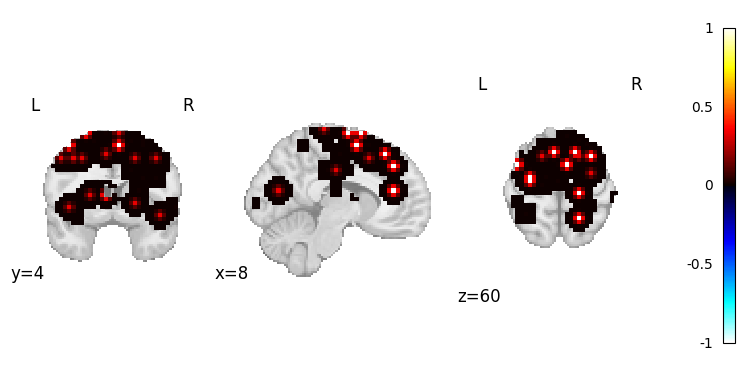

In [7]:
# Plot an example
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()
plot_stat_map(masker.inverse_transform(neuro_vectors[1072]), cut_coords=np.array([8, 4, 60]),
              cmap="cold_hot", vmin=-1, vmax=1, draw_cross=False);